In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, BatchNormalization, LeakyReLU, Conv2DTranspose, AveragePooling2D, Concatenate, Add, UpSampling2D, Activation
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import sys
import importlib
import matplotlib.pyplot as plt
import time
import keras.backend as K
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/DLProjects/JapaNet

Mounted at /content/gdrive
/content/gdrive/My Drive/DLProjects/JapaNet


In [3]:
from dataloader import IdentifierDataset

In [4]:
datasetParams = {
    'identifierShufflingBufferSize': 4096,
    'classifierShufflingBufferSize': 100,
    'batchSize': 32,
    'identifierInputHeight': 512,
    'identifierInputWidth': 512,
    'identifierOutputStride': 4,
    'validationFraction': 0.2,
    'classifierInputWidth': 64,
    'classifierInputHeight': 64
}

dataset = IdentifierDataset(datasetParams)
trainData, validationData = dataset.load()

In [ ]:
def aggregation_block(x_shallow, x_deep, deep_ch, out_ch):
    x_deep= Conv2DTranspose(deep_ch, kernel_size=2, strides=2, padding='same', use_bias=False)(x_deep)
    x_deep = BatchNormalization()(x_deep)   
    x_deep = LeakyReLU(alpha=0.1)(x_deep)
    x = Concatenate()([x_shallow, x_deep])
    x=Conv2D(out_ch, kernel_size=1, strides=1, padding="same")(x)
    x = BatchNormalization()(x)   
    x = LeakyReLU(alpha=0.1)(x)
    return x



def cbr(x, out_layer, kernel, stride):
    x=Conv2D(out_layer, kernel_size=kernel, strides=stride, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    return x

def resblock(x_in,layer_n):
    x=cbr(x_in,layer_n,3,1)
    x=cbr(x,layer_n,3,1)
    x=Add()([x,x_in])
    return x  


def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

def create_model(input_shape, size_detection_mode=True, aggregation=True):
    input_layer = Input(input_shape)

    # resized input
    input_layer_1 = AveragePooling2D(2)(input_layer)
    input_layer_2 = AveragePooling2D(2)(input_layer_1)

    #### ENCODER ####

    x_0 = cbr(input_layer, 16, 3, 2)  # 512->256
    concat_1 = Concatenate()([x_0, input_layer_1])

    x_1 = cbr(concat_1, 32, 3, 2)  # 256->128
    concat_2 = Concatenate()([x_1, input_layer_2])

    x_2 = cbr(concat_2, 64, 3, 2)  # 128->64

    x = cbr(x_2, 64, 3, 1)
    x = resblock(x, 64)
    x = resblock(x, 64)

    x_3 = cbr(x, 128, 3, 2)  # 64->32
    x = cbr(x_3, 128, 3, 1)
    x = resblock(x, 128)
    x = resblock(x, 128)
    x = resblock(x, 128)

    x_4 = cbr(x, 256, 3, 2)  # 32->16
    x = cbr(x_4, 256, 3, 1)
    x = resblock(x, 256)
    x = resblock(x, 256)
    x = resblock(x, 256)
    x = resblock(x, 256)
    x = resblock(x, 256)

    x_5 = cbr(x, 512, 3, 2)  # 16->8
    x = cbr(x_5, 512, 3, 1)

    x = resblock(x, 512)
    x = resblock(x, 512)
    x = resblock(x, 512)

    if size_detection_mode:
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.2)(x)
        out = Dense(1, activation="linear")(x)

    else:  # centernet mode
        output_layer_n = 5
        #### DECODER ####
        x_1 = cbr(x_1, output_layer_n, 1, 1)
        x_1 = aggregation_block(x_1, x_2, output_layer_n, output_layer_n)
        x_2 = cbr(x_2, output_layer_n, 1, 1)
        x_2 = aggregation_block(x_2, x_3, output_layer_n, output_layer_n)
        x_1 = aggregation_block(x_1, x_2, output_layer_n, output_layer_n)
        x_3 = cbr(x_3, output_layer_n, 1, 1)
        x_3 = aggregation_block(x_3, x_4, output_layer_n, output_layer_n)
        x_2 = aggregation_block(x_2, x_3, output_layer_n, output_layer_n)
        x_1 = aggregation_block(x_1, x_2, output_layer_n, output_layer_n)

        x_4 = cbr(x_4, output_layer_n, 1, 1)

        x = cbr(x, output_layer_n, 1, 1)
        x = UpSampling2D(size=(2, 2))(x)  # 8->16 

        x = Concatenate()([x, x_4])
        x = cbr(x, output_layer_n, 3, 1)
        x = UpSampling2D(size=(2, 2))(x)  # 16->32

        x = Concatenate()([x, x_3])
        x = cbr(x, output_layer_n, 3, 1)
        x = UpSampling2D(size=(2, 2))(x)  # 32->64   

        x = Concatenate()([x, x_2])
        x = cbr(x, output_layer_n, 3, 1)
        x = UpSampling2D(size=(2, 2))(x)  # 64->128 

        x = Concatenate()([x, x_1])
        x = Conv2D(output_layer_n, kernel_size=3, strides=1, padding="same")(x)
        out = Activation("sigmoid")(x)

    model = Model(input_layer, out)

    return model

# Create an instance of the model
model = create_model((512, 512, 3), size_detection_mode=False)

In [ ]:
from keras.callbacks import LearningRateScheduler

def lrs(epoch):
    lr = 0.001
    if epoch >= 20: 
        lr = 0.0002
    return lr

lr_schedule = LearningRateScheduler(lrs)

In [ ]:
category_n = 1

def all_loss(y_true, y_pred):
    mask = K.sign(y_true[:, :, :, 1])
    N = K.sum(mask)
    alpha = 2.
    beta = 4.
    heatmap_true = y_true[:, :, :, 0]
    heatmap_pred = y_pred[:, :, :, 0]
    heatloss = -K.sum(heatmap_true*((1-heatmap_pred)**alpha)*K.log(heatmap_pred+1e-6)+(1-heatmap_true)*((1-mask)**beta)*(heatmap_pred**alpha)*K.log(1-heatmap_pred+1e-6))
    offsetloss = K.sum(K.abs(y_true[:, :, :, 3]-y_pred[:, :, :, 3]*mask)+K.abs(y_true[:, :, :, 4]-y_pred[:, :, :, 4]*mask))
    sizeloss = K.sum(K.abs(y_true[:, :, :, 1]-y_pred[:, :, :, 1]*mask)+K.abs(y_true[:, :, :, 2]-y_pred[:, :, :, 2]*mask))
    all_loss = (heatloss+1.0*offsetloss+5.0*sizeloss)/N
    return all_loss

def model_fit_centernet(model, trainData, valData, n_epoch):
    hist = model.fit(
        trainData,
        epochs = n_epoch,
        # validation_data=valData,
        callbacks = [lr_schedule],
        verbose = 1
    )
    return hist

learning_rate=0.001
n_epoch=30
batch_size=32
model.compile(loss=all_loss, optimizer=Adam(lr=learning_rate))
hist = model_fit_centernet(model, trainData, validationData, 30)

Epoch 1/30
90/90 [==============================] - 29s 190ms/step - loss: 6.2306
Epoch 2/30
90/90 [==============================] - 17s 191ms/step - loss: 1.4565
Epoch 3/30
90/90 [==============================] - 17s 190ms/step - loss: 1.2716
Epoch 4/30
90/90 [==============================] - 17s 190ms/step - loss: 1.1891
Epoch 5/30
90/90 [==============================] - 17s 190ms/step - loss: 1.1275
Epoch 6/30
90/90 [==============================] - 17s 189ms/step - loss: 1.0770
Epoch 7/30
90/90 [==============================] - 17s 189ms/step - loss: 1.0430
Epoch 8/30
90/90 [==============================] - 17s 191ms/step - loss: 0.9955
Epoch 9/30
90/90 [==============================] - 17s 189ms/step - loss: 0.9618
Epoch 10/30
90/90 [==============================] - 17s 191ms/step - loss: 0.9324
Epoch 11/30
90/90 [==============================] - 17s 192ms/step - loss: 0.9117
Epoch 12/30
90/90 [==============================] - 17s 190ms/step - loss: 0.8973
Epoch 13/30
9

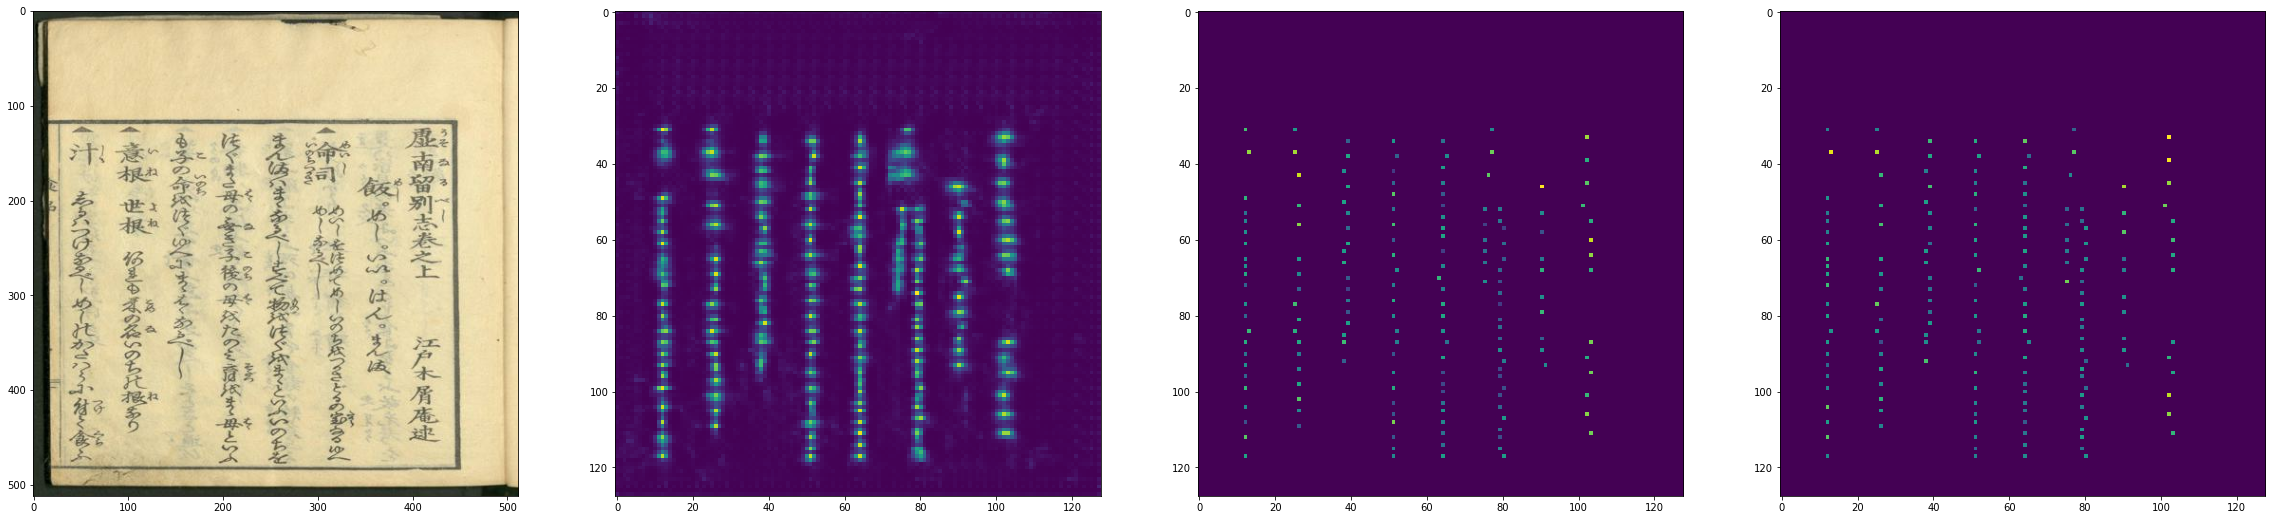

In [ ]:
imgIdx = 0
for image, label in validationData:
    x = model.predict(tf.reshape(image[imgIdx, :, :, :], (1, 512, 512, 3)))
    break
plt.figure(figsize=(40,10))
plt.subplot(1, 4, 1)
plt.imshow(image[imgIdx, :, :, :])
plt.subplot(1, 4, 2)
plt.imshow(x[0, :, :, 0])
plt.subplot(1, 4, 3)
plt.imshow(x[0, :, :, 1] * np.sign(label[imgIdx, :, :, 1])) 
plt.subplot(1, 4, 4)
plt.imshow(x[0, :, :, 2] * np.sign(label[imgIdx, :, :, 1]))